In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [2]:
train_targets = pd.read_parquet('./data/A/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/A/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')

In [3]:
df = pd.concat([X_train_observed, X_train_estimated])
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')
df = df.drop(columns=['date_calc', 'date_forecast'])
df = df.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], axis=1)

imputer = SimpleImputer(strategy='mean')
df[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(df[['ceiling_height_agl:m', 'cloud_base_agl:m']])

X = df.drop(columns=['pv_measurement', 'time']) # Drop the index, target, and time columns
y = df['pv_measurement'] # Target variable

In [17]:
# Define the split date
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]


# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
29667                       8.4                1.233           1425.099976   
29668                       8.2                1.233           4068.199951   
29669                       8.2                1.230           1978.000000   
29670                       8.1                1.229           1722.000000   
29671                       8.3                1.228           1456.400024   
...                         ...                  ...                   ...   
34056                       4.6                1.275           1633.000000   
34057                       4.5                1.279           1742.900024   
34058                       4.5                1.281           1794.900024   
34059                       4.5                1.281           1532.900024   
34060                       4.5                1.281           1054.199951   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m

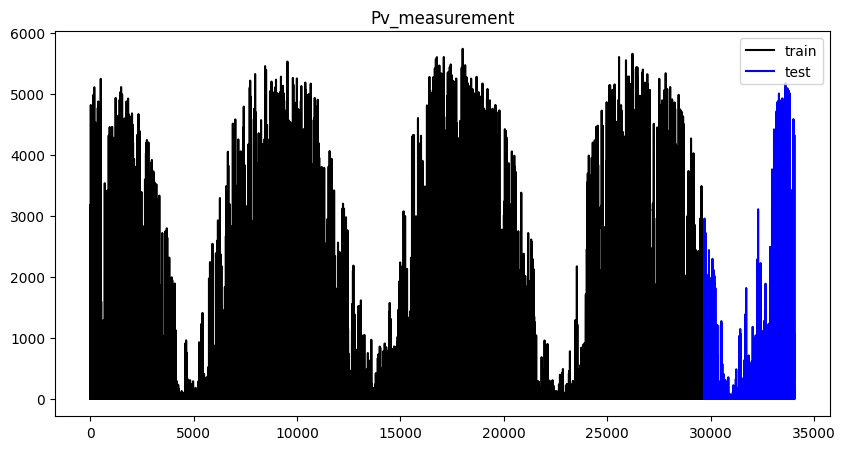

In [5]:
y_train.plot(style='k', figsize=(10, 5), label='train')
y_test.plot(style='b', figsize=(10, 5), label='test')

plt.title('Pv_measurement')
plt.legend()

# First Baseline Model: XGBoost

In [6]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

133.04618613556076

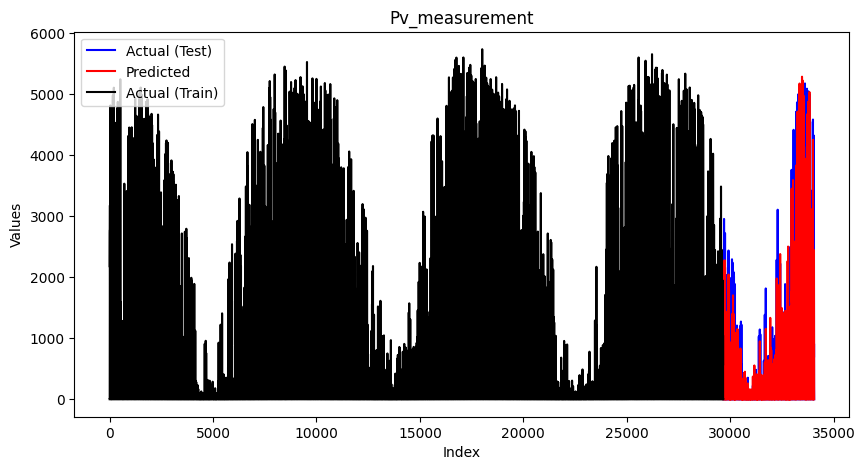

In [7]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Actual'], 'b', label='Actual (Test)')
plt.plot(results_df.index, results_df['Predicted'], 'r', label='Predicted')
plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
plt.title('Pv_measurement')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

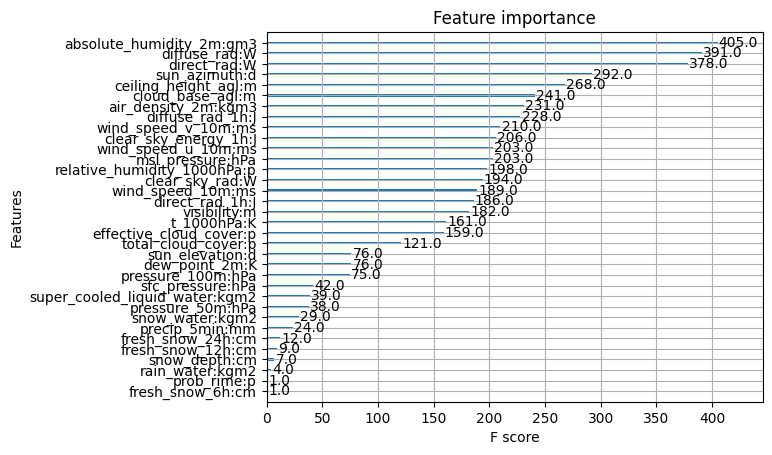

In [8]:
xgb.plot_importance(xgb_model)
plt.show()

In [18]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter
    return df

df = date_features(df)

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,time,pv_measurement,hour,day,month,quarter,is_estimated
0,7.7,1.230,1744.900024,0.000000,0.0,1744.900024,0.0,280.299988,0.0,0.000000,...,-3.6,-0.8,-0.0,2019-06-02 22:00:00,0.00,22,153,6,2,0
1,7.7,1.225,1703.599976,0.000000,0.0,1703.599976,0.0,280.299988,0.0,0.000000,...,-3.5,0.0,-0.0,2019-06-02 23:00:00,0.00,23,153,6,2,0
2,7.7,1.221,1668.099976,0.000000,0.0,1668.099976,0.0,280.200012,0.0,0.000000,...,-3.1,0.7,-0.0,2019-06-03 00:00:00,0.00,0,154,6,2,0
3,8.2,1.218,1388.400024,0.000000,0.0,1388.400024,0.0,281.299988,0.0,0.000000,...,-2.7,0.8,-0.0,2019-06-03 01:00:00,0.00,1,154,6,2,0
4,8.8,1.219,1108.500000,6546.899902,9.8,1108.500000,0.0,282.299988,4.3,7743.299805,...,-2.5,1.0,-0.0,2019-06-03 02:00:00,19.36,2,154,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,4.6,1.275,1633.000000,157319.796875,13.5,547.500000,0.0,272.500000,8.9,94492.000000,...,5.1,1.8,-0.0,2023-04-30 19:00:00,9.02,19,120,4,2,1
34057,4.5,1.279,1742.900024,8133.899902,0.0,534.700012,0.0,272.299988,0.0,15967.400391,...,4.2,2.1,-0.0,2023-04-30 20:00:00,0.00,20,120,4,2,1
34058,4.5,1.281,1794.900024,0.000000,0.0,565.900024,0.0,272.299988,0.0,0.000000,...,3.7,2.6,-0.0,2023-04-30 21:00:00,0.00,21,120,4,2,1
34059,4.5,1.281,1532.900024,0.000000,0.0,519.000000,0.0,272.299988,0.0,0.000000,...,3.4,2.6,-0.0,2023-04-30 22:00:00,0.00,22,120,4,2,1


In [19]:
def is_estimated(df):
    split_date = '2022-10-27'
    df['is_estimated'] = 0  # Initialize with 0 (indicating observed)
    df.loc[df['time'] >= pd.Timestamp(split_date), 'is_estimated'] = 1  # Set 1 for estimated data
    return df

df = is_estimated(df)

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,time,pv_measurement,hour,day,month,quarter,is_estimated
0,7.7,1.230,1744.900024,0.000000,0.0,1744.900024,0.0,280.299988,0.0,0.000000,...,-3.6,-0.8,-0.0,2019-06-02 22:00:00,0.00,22,153,6,2,0
1,7.7,1.225,1703.599976,0.000000,0.0,1703.599976,0.0,280.299988,0.0,0.000000,...,-3.5,0.0,-0.0,2019-06-02 23:00:00,0.00,23,153,6,2,0
2,7.7,1.221,1668.099976,0.000000,0.0,1668.099976,0.0,280.200012,0.0,0.000000,...,-3.1,0.7,-0.0,2019-06-03 00:00:00,0.00,0,154,6,2,0
3,8.2,1.218,1388.400024,0.000000,0.0,1388.400024,0.0,281.299988,0.0,0.000000,...,-2.7,0.8,-0.0,2019-06-03 01:00:00,0.00,1,154,6,2,0
4,8.8,1.219,1108.500000,6546.899902,9.8,1108.500000,0.0,282.299988,4.3,7743.299805,...,-2.5,1.0,-0.0,2019-06-03 02:00:00,19.36,2,154,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,4.6,1.275,1633.000000,157319.796875,13.5,547.500000,0.0,272.500000,8.9,94492.000000,...,5.1,1.8,-0.0,2023-04-30 19:00:00,9.02,19,120,4,2,1
34057,4.5,1.279,1742.900024,8133.899902,0.0,534.700012,0.0,272.299988,0.0,15967.400391,...,4.2,2.1,-0.0,2023-04-30 20:00:00,0.00,20,120,4,2,1
34058,4.5,1.281,1794.900024,0.000000,0.0,565.900024,0.0,272.299988,0.0,0.000000,...,3.7,2.6,-0.0,2023-04-30 21:00:00,0.00,21,120,4,2,1
34059,4.5,1.281,1532.900024,0.000000,0.0,519.000000,0.0,272.299988,0.0,0.000000,...,3.4,2.6,-0.0,2023-04-30 22:00:00,0.00,22,120,4,2,1


In [11]:
# Define the split date
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

In [12]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/marioharoun/opt/anaconda3/envs/tdt4173proj/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

132.10059928967428

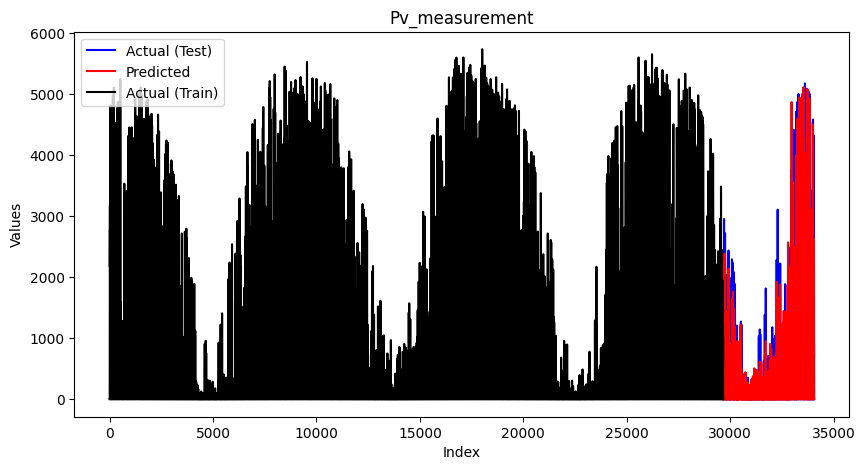

In [13]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Actual'], 'b', label='Actual (Test)')
plt.plot(results_df.index, results_df['Predicted'], 'r', label='Predicted')
plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
plt.title('Pv_measurement')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

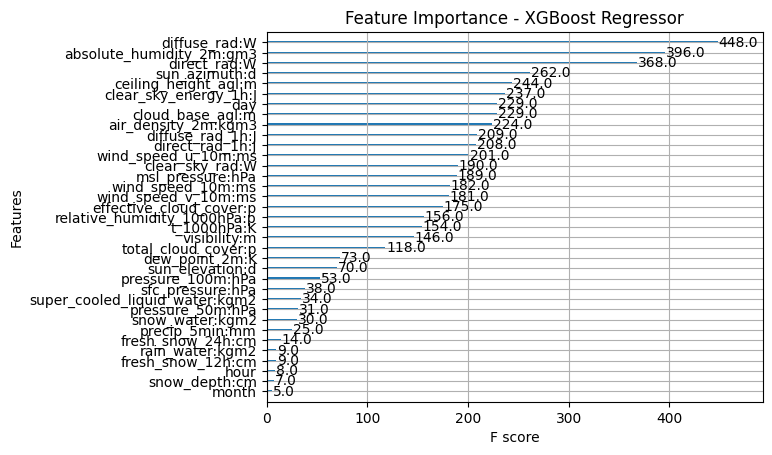

In [14]:
xgb.plot_importance(xgb_model, importance_type='weight')  # You can adjust 'max_num_features' as needed
plt.title("Feature Importance - XGBoost Regressor")
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search on the training data (assuming X_train_a and y_train_a are your training data)
grid_search.fit(X_train_a, y_train_a)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

NameError: name 'X_train_a' is not defined

# E2E model to deliverable, simple optuna tuning
- Only using hourly data (not quarterly)
- no care taken to bad data in location B and C
    - other than filling with mean and dropping
- one model for all locations, location added as feature


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings('ignore')


### Loading and reparing data

In [2]:
A_train_targets = pd.read_parquet('./data/A/train_targets.parquet')
A_X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
A_X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')
A_X_test = pd.read_parquet('./data/A/X_test_estimated.parquet')

B_train_targets = pd.read_parquet('./data/B/train_targets.parquet')
B_X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
B_X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')
B_X_test = pd.read_parquet('./data/B/X_test_estimated.parquet')

C_train_targets = pd.read_parquet('./data/B/train_targets.parquet')
C_X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
C_X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')
C_X_test = pd.read_parquet('./data/B/X_test_estimated.parquet')

X_train_estimated = {
    'A': A_X_train_estimated,
    'B': B_X_train_estimated,
    'C': C_X_train_estimated,
}
X_train_observed = {
    'A': A_X_train_observed,
    'B': B_X_train_observed,
    'C': C_X_train_observed,
}
train_targets = {
    'A': A_train_targets,
    'B': B_train_targets,
    'C': C_train_targets,
}
X_test_submission = {
    'A': A_X_test,
    'B': B_X_test,
    'C': C_X_test,
}

preparation:
result is a single dictionary `train_set_merged` with the keys `A`, `B` and `C`, for each corresponding location. one new feature is added: `location`, and the prediction-target is added as a columns as well: `y`

In [4]:
# Marking each row with its location origin
for location in X_train_estimated.keys():
    X_train_estimated[location]['location'] = location
    X_train_observed[location]['location'] = location
    X_test_submission[location]['location'] = location
    X_train_estimated[location]['location'] = X_train_estimated[location]['location'].astype('category')
    X_train_observed[location]['location'] = X_train_observed[location]['location'].astype('category')
    X_test_submission[location]['location'] = X_test_submission[location]['location'].astype('category')

# Making a test set for each location
train_set_merged = {}
for location in X_train_estimated.keys():
    # concatinating observed and estimated
    concatinated = pd.concat(
        [X_train_observed[location], X_train_estimated[location]]
    )
    
    # merging target value into the training set
    merged = pd.merge(
        concatinated,
        train_targets[location],
        left_on='date_forecast',
        right_on='time',
        how='inner'
    )


    # dropping dates
    merged = merged.drop(columns=['date_calc', 'date_forecast'])

    # dropping some other shit
    merged = merged.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J'], axis=1)

    # filling bad samples
    imputer = SimpleImputer(strategy='mean')
    merged[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(merged[['ceiling_height_agl:m', 'cloud_base_agl:m']])

    # remove bad values
    # merged['pv_measurement'].replace(0.0, np.nan, inplace=True)

    # # Remove rows with NaN values in the 'pv_measurement' column
    # merged.dropna(subset=['pv_measurement'], inplace=True)

    # Use the mask to filter both X_train and y_train

    # Filling rows with NaN values
    # Define the default fill value
    # Identify categorical columns
    categorical_columns = merged.select_dtypes(include='category').columns

    # Exclude categorical columns from the fill operation
    for col in merged.columns:
        if col not in categorical_columns:
            merged[col] = merged[col].fillna(merged[col].mean())


    train_set_merged[location] = merged


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,direct_rad:W,effective_cloud_cover:p,...,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,time,pv_measurement
0,7.7,1.230,1744.900024,0.0,1744.900024,0.0,280.299988,0.0,0.0,98.699997,...,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,A,2019-06-02 22:00:00,0.00
1,7.7,1.225,1703.599976,0.0,1703.599976,0.0,280.299988,0.0,0.0,99.599998,...,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,A,2019-06-02 23:00:00,0.00
2,7.7,1.221,1668.099976,0.0,1668.099976,0.0,280.200012,0.0,0.0,100.000000,...,287.000000,100.000000,20473.000000,3.2,-3.1,0.7,-0.0,A,2019-06-03 00:00:00,0.00
3,8.2,1.218,1388.400024,0.0,1388.400024,0.0,281.299988,0.0,0.0,100.000000,...,286.899994,100.000000,2104.600098,2.8,-2.7,0.8,-0.0,A,2019-06-03 01:00:00,0.00
4,8.8,1.219,1108.500000,9.8,1108.500000,0.0,282.299988,4.3,0.0,100.000000,...,286.500000,100.000000,2681.600098,2.7,-2.5,1.0,-0.0,A,2019-06-03 02:00:00,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,4.6,1.275,1633.000000,13.5,547.500000,0.0,272.500000,8.9,0.4,98.800003,...,275.200012,98.800003,25598.000000,5.4,5.1,1.8,-0.0,A,2023-04-30 19:00:00,9.02
34057,4.5,1.279,1742.900024,0.0,534.700012,0.0,272.299988,0.0,0.0,94.599998,...,274.700012,94.599998,19760.900391,4.7,4.2,2.1,-0.0,A,2023-04-30 20:00:00,0.00
34058,4.5,1.281,1794.900024,0.0,565.900024,0.0,272.299988,0.0,0.0,93.699997,...,274.600006,94.599998,23291.400391,4.5,3.7,2.6,-0.0,A,2023-04-30 21:00:00,0.00
34059,4.5,1.281,1532.900024,0.0,519.000000,0.0,272.299988,0.0,0.0,95.400002,...,274.399994,97.400002,16674.900391,4.3,3.4,2.6,-0.0,A,2023-04-30 22:00:00,0.00


### Split into test-set and train-set

In [5]:
# split_date = '2022-12-27' # use this when locally testing
split_date = '2023-04-20' # use this when producing submitted file

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for location in train_set_merged.keys():
    set = train_set_merged[location]
    set['time'] = pd.to_datetime(train_set_merged[location]['time'])
    set.sort_values('time', inplace=True)

    train_set = set[set['time'] < split_date]
    test_set = set[set['time'] >= split_date]

    X_train = train_set.drop(columns=['pv_measurement'])
    y_train = train_set['pv_measurement']
    X_test = test_set.drop(columns=['pv_measurement'])
    y_test = test_set['pv_measurement']


    X_train_dict[location] = X_train
    y_train_dict[location] = y_train
    X_test_dict[location] = X_test
    y_test_dict[location] = y_test

    

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,direct_rad:W,effective_cloud_cover:p,...,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,time,pv_measurement
0,7.7,1.230,1744.900024,0.0,1744.900024,0.0,280.299988,0.0,0.0,98.699997,...,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,A,2019-06-02 22:00:00,0.00
1,7.7,1.225,1703.599976,0.0,1703.599976,0.0,280.299988,0.0,0.0,99.599998,...,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,A,2019-06-02 23:00:00,0.00
2,7.7,1.221,1668.099976,0.0,1668.099976,0.0,280.200012,0.0,0.0,100.000000,...,287.000000,100.000000,20473.000000,3.2,-3.1,0.7,-0.0,A,2019-06-03 00:00:00,0.00
3,8.2,1.218,1388.400024,0.0,1388.400024,0.0,281.299988,0.0,0.0,100.000000,...,286.899994,100.000000,2104.600098,2.8,-2.7,0.8,-0.0,A,2019-06-03 01:00:00,0.00
4,8.8,1.219,1108.500000,9.8,1108.500000,0.0,282.299988,4.3,0.0,100.000000,...,286.500000,100.000000,2681.600098,2.7,-2.5,1.0,-0.0,A,2019-06-03 02:00:00,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,4.6,1.275,1633.000000,13.5,547.500000,0.0,272.500000,8.9,0.4,98.800003,...,275.200012,98.800003,25598.000000,5.4,5.1,1.8,-0.0,A,2023-04-30 19:00:00,9.02
34057,4.5,1.279,1742.900024,0.0,534.700012,0.0,272.299988,0.0,0.0,94.599998,...,274.700012,94.599998,19760.900391,4.7,4.2,2.1,-0.0,A,2023-04-30 20:00:00,0.00
34058,4.5,1.281,1794.900024,0.0,565.900024,0.0,272.299988,0.0,0.0,93.699997,...,274.600006,94.599998,23291.400391,4.5,3.7,2.6,-0.0,A,2023-04-30 21:00:00,0.00
34059,4.5,1.281,1532.900024,0.0,519.000000,0.0,272.299988,0.0,0.0,95.400002,...,274.399994,97.400002,16674.900391,4.3,3.4,2.6,-0.0,A,2023-04-30 22:00:00,0.00


### Truncate data into single set, regardless of location

In [ ]:
X_train_concatinated = pd.concat(X_train_dict.values())
y_train_concatinated = pd.concat(y_train_dict.values())
X_train_concatinated['location'] = X_train_concatinated['location'].astype('category')

X_test_concatinated = pd.concat(X_test_dict.values())
y_test_concatinated = pd.concat(y_test_dict.values())
X_test_concatinated['location'] = X_test_concatinated['location'].astype('category')



### Train model

In [ ]:
# make copy without time
X_train_concatinated_timeless = X_train_concatinated.drop(columns=['time'])
X_test_concatinated_timeless = X_test_concatinated.drop(columns=['time'])

X_train_timeless = X_train_dict.copy()
X_test_timeless = X_test_dict.copy()
for location in X_test_dict.keys():
    X_train_timeless[location] = X_train_dict[location].drop(columns=['time'])
    X_test_timeless[location] = X_test_dict[location].drop(columns=['time'])

In [ ]:
import xgboost as xgb
import optuna

## hyperparameter-tuning
def objective(trial):
    params = {
        "enable_categorical": True,
        "objective": "reg:squarederror",
        "n_estimators": 300,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_concatinated_timeless, y_train_concatinated, verbose=False)
    predictions = model.predict(X_test_concatinated_timeless)
    mae = mean_absolute_error(y_test_concatinated, predictions)
    return mae


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)




[I 2023-10-15 19:13:53,005] A new study created in memory with name: no-name-b1152f4b-3626-4d11-b931-3b203990c29c
[I 2023-10-15 19:13:55,670] Trial 0 finished with value: 217.50657356116878 and parameters: {'learning_rate': 0.029030296837341242, 'max_depth': 2, 'subsample': 0.9684932634054343, 'colsample_bytree': 0.19624282481288274, 'min_child_weight': 3}. Best is trial 0 with value: 217.50657356116878.
[I 2023-10-15 19:13:59,210] Trial 1 finished with value: 269.7887625199184 and parameters: {'learning_rate': 0.03960427766646431, 'max_depth': 6, 'subsample': 0.32000897855657084, 'colsample_bytree': 0.05156475862630102, 'min_child_weight': 12}. Best is trial 0 with value: 217.50657356116878.
[I 2023-10-15 19:14:03,330] Trial 2 finished with value: 136.36827995129806 and parameters: {'learning_rate': 0.09349923363311362, 'max_depth': 6, 'subsample': 0.1393884561412887, 'colsample_bytree': 0.6912034741498121, 'min_child_weight': 15}. Best is trial 2 with value: 136.36827995129806.
[W 20

KeyboardInterrupt: 

In [ ]:

best_params = {'learning_rate': 0.02086191640058873, 'max_depth': 9, 'subsample': 0.42494886946569993, 'colsample_bytree': 0.7870843962802936, 'min_child_weight': 17}

xgb_model = xgb.XGBRegressor(enable_categorical=True, n_estimators=300, **best_params)
xgb_model.fit(X_train_concatinated_timeless, y_train_concatinated, verbose=False)
predictions = xgb_model.predict(X_test_concatinated_timeless)
mae = mean_absolute_error(y_test_concatinated, predictions)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test_concatinated, predictions)
mae


127.83087632171942

### use trained model to generate submission file

In [ ]:
columns_to_drop = ['date_forecast', 'date_calc', 'elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J']

X_test_submission_concatinated = pd.concat(X_test_submission.values())
X_test_submission_concatinated['location'] = X_test_submission_concatinated['location'].astype('category')
# X_test_submission_concatinated_pred = X_test_submission_concatinated.copy()
# X_test_submission_concatinated_pred['prediction'] = xgb_model.predict(X_test_submission_concatinated.drop(columns=columns_to_drop))

# X_test_submission_pred = X_test_submission.copy()
# for location in X_test_submission.keys():
#     X_test_submission_pred[location]['prediction'] = xgb_model.predict(X_test_submission[location].drop(columns=columns_to_drop))




In [ ]:
def gen_pred_csv_from_trained_model(model, X_test, test_csv_path, sample_submission_csv_path, columns_to_drop):
    predictions = model.predict(X_test.drop(columns=columns_to_drop))
    X_test_with_prediction = X_test.copy()
    X_test_with_prediction['prediction'] = predictions

    X_test_with_prediction

    test_csv = pd.read_csv(test_csv_path)
    test_csv['time'] = pd.to_datetime(test_csv['time'])

    sample_submission = pd.merge(test_csv, X_test_with_prediction, left_on=['time', 'location'], right_on=['date_forecast', 'location'], how='inner')
    sample_submission = sample_submission[['id', 'prediction_y']]
    sample_submission = sample_submission.rename(columns={'prediction_y': 'prediction'})
    sample_submission['prediction'] = sample_submission['prediction'].apply(lambda x: max(0, x))

    sample_submission.to_csv(sample_submission_csv_path, index=False)

gen_pred_csv_from_trained_model(
    model=xgb_model,
    X_test=X_test_submission_concatinated,
    test_csv_path='data/test.csv',
    sample_submission_csv_path='data/sample_submission.csv',
    columns_to_drop=['date_forecast', 'date_calc', 'elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J']
)


# Deep Learning for Time Seriers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Prepare the date

In [3]:
A_train_targets = pd.read_parquet('./data/A/train_targets.parquet')
A_X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
A_X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')
A_X_test = pd.read_parquet('./data/A/X_test_estimated.parquet')

B_train_targets = pd.read_parquet('./data/B/train_targets.parquet')
B_X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
B_X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')
B_X_test = pd.read_parquet('./data/B/X_test_estimated.parquet')

C_train_targets = pd.read_parquet('./data/B/train_targets.parquet')
C_X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
C_X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')
C_X_test = pd.read_parquet('./data/B/X_test_estimated.parquet')

X_train_estimated = {
    'A': A_X_train_estimated,
    'B': B_X_train_estimated,
    'C': C_X_train_estimated,
}
X_train_observed = {
    'A': A_X_train_observed,
    'B': B_X_train_observed,
    'C': C_X_train_observed,
}
train_targets = {
    'A': A_train_targets,
    'B': B_train_targets,
    'C': C_train_targets,
}
X_test_submission = {
    'A': A_X_test,
    'B': B_X_test,
    'C': C_X_test,
}

In [4]:
# Marking each row with its location origin
for location in X_train_estimated.keys():
    X_train_estimated[location]['location'] = location
    X_train_observed[location]['location'] = location
    X_test_submission[location]['location'] = location
    X_train_estimated[location]['location'] = X_train_estimated[location]['location'].astype('category')
    X_train_observed[location]['location'] = X_train_observed[location]['location'].astype('category')
    X_test_submission[location]['location'] = X_test_submission[location]['location'].astype('category')

# Making a test set for each location
train_set_merged = {}
for location in X_train_estimated.keys():
    # concatinating observed and estimated
    concatinated = pd.concat(
        [X_train_observed[location], X_train_estimated[location]]
    )
    
    # merging target value into the training set
    merged = pd.merge(
        concatinated,
        train_targets[location],
        left_on='date_forecast',
        right_on='time',
        how='inner'
    )

    # dropping dates
    merged = merged.drop(columns=['date_calc', 'date_forecast'])

    # dropping some other shit
    merged = merged.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J'], axis=1)

    # filling bad samples
    imputer = SimpleImputer(strategy='mean')
    merged[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(merged[['ceiling_height_agl:m', 'cloud_base_agl:m']])

    # Filling rows with NaN values
    # Define the default fill value
    # Identify categorical columns
    categorical_columns = merged.select_dtypes(include='category').columns

    # Exclude categorical columns from the fill operation
    for col in merged.columns:
        if col not in categorical_columns:
            merged[col] = merged[col].fillna(merged[col].mean())


    train_set_merged[location] = merged

split_date = '2022-12-27' # use this when locally testing
# split_date = '2023-04-20' # use this when producing submitted file

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for location in train_set_merged.keys():
    set = train_set_merged[location]
    set['time'] = pd.to_datetime(train_set_merged[location]['time'])
    set.sort_values('time', inplace=True)

    train_set = set[set['time'] < split_date]
    test_set = set[set['time'] >= split_date]

    X_train = train_set.drop(columns=['pv_measurement'])
    y_train = train_set['pv_measurement']
    X_test = test_set.drop(columns=['pv_measurement'])
    y_test = test_set['pv_measurement']


    X_train_dict[location] = X_train
    y_train_dict[location] = y_train
    X_test_dict[location] = X_test
    y_test_dict[location] = y_test

In [5]:
X_train = X_train_dict['A'].drop(columns=['time', 'location'])
X_test = X_test_dict['A'].drop(columns=['time', 'location'])
y_train = y_train_dict['A']
y_test = y_test_dict['A']

# plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
# plt.plot(y_test.index, y_test, 'b', label='Actual (Test)')
# plt.title('Pv_measurement')
# plt.xlabel('Index')
# plt.ylabel('Values')
# plt.legend()


In [8]:
def create_dataset(dataset, lookback):
    """
    Transform a pandas Dataframe into a prediction dataset
    Returns a tuple of tourch tensors of the form (X, y)
    Args:
        dataset: A dataframe of time series
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        a = dataset[i:(i + lookback)].values
        X.append(a)
        y.append(dataset.iloc[i + lookback])
    return torch.tensor(X), torch.tensor(y)

X_train_tensor, y_train_tensor = create_dataset(y_train, 24)
X_test_tensor, y_test_tensor = create_dataset(y_test, 24)

print(X_train_tensor)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [28]:
class LSTMModel(nn.Module):

    def __init__(self, input_size=X_train_tensor.shape[1], hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss = nn.L1Loss() # L1 loss (mean_absolute_error)
loader = torch.utils.data.DataLoader(list(zip(X_train_tensor, y_train_tensor)), batch_size=32, shuffle=True)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch.float())
        l = loss(y_pred, y_batch.float())
        l.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.float())
        l = loss(y_pred, y_test_tensor.float())
        print(f'Epoch {epoch}: {l.item()}')


## -----

# # Training the model
# for epoch in range(num_epochs):
#     outputs = model(X_train.float())
#     optimizer.zero_grad()
#     loss = loss(outputs, y_train.float())
#     loss.backward()
#     optimizer.step()

# # Make predictions on the test data
# model.eval()
# with torch.no_grad():
#     test_predictions = model(X_test)
#     test_predictions = test_predictions.numpy()

# # Calculate and print MAE for evaluation
# mae = mean_absolute_error(y_test, test_predictions)
# print(f"MAE for location 'A': {mae}")

Epoch 0: 447.14599609375
Epoch 1: 447.1260681152344
Epoch 2: 447.28704833984375
Epoch 3: 448.5519714355469
Epoch 4: 447.1787109375
Epoch 5: 447.5726318359375
Epoch 6: 450.071044921875
Epoch 7: 447.521728515625
Epoch 8: 452.8882751464844
Epoch 9: 453.3060302734375


## Model training

In [24]:
class LSTMModel(nn.Module):

    def __init__(self, hidden_size, num_layers, output_size, input_size=34061):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Take the last time step's output
        return out
    

# Define hyperparameters
input_size = X_train_dict['A'].shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

# Prepare the data for location 'A'
X_train = X_train_dict['A']
y_train = y_train_dict['A']
X_test = X_test_dict['A']
y_test = y_test_dict['A']

# Drop the 'time' and 'location' columns and convert the target variable to float32
X_train = X_train.drop(columns=['time', 'location'])
X_test = X_test.drop(columns=['time', 'location'])
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Convert data to PyTorch tensors
X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)


# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Make predictions on the test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.numpy()

# Calculate and print MAE for evaluation
mae = mean_absolute_error(y_test, test_predictions)
print(f"MAE for location 'A': {mae}")

IndexError: too many indices for tensor of dimension 2